Log level was: DEBUG
Log level is now: WARNING

 Custom plotting style: 'scientific.mplstyle' 

 Custom Colormaps:


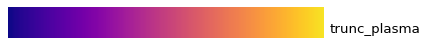

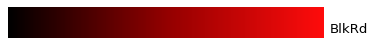

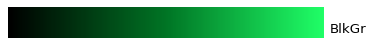

In [1]:
#@title ### 📥🌐 Install & Import external libraries (FEniCS - Dolfin) { form-width: "40%" }


from dolfin import *
from mpi4py import MPI

import logging
ffc_logger = logging.getLogger('FFC')
print('Log level was:', logging.getLevelName(ffc_logger.getEffectiveLevel()))
ffc_logger.setLevel(logging.WARNING)
print( 'Log level is now:', logging.getLevelName(ffc_logger.getEffectiveLevel()))


#@markdown ### 🐍 Import standard Python libraries  

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors


#@markdown ### 📊 Plotting utilities

### style utility::: scientific.mplstyle 

str_mplstyle = '''
# Figure properties
figure.figsize: 4, 4

# Font properties
font.family: cmr10
font.size: 14
mathtext.fontset: cm
axes.unicode_minus: False


# SPINE COLORS  -- GRAY
axes.edgecolor:      2B2B2B     
text.color:          2B2B2B
axes.labelcolor:     2B2B2B
xtick.color:         2B2B2B
ytick.color:         2B2B2B

# Axes properties
axes.linewidth: 2
axes.labelpad: 10
axes.prop_cycle: cycler(color=['008fd5', 'fc4f30', 'e5ae38', '6d904f', '8b8b8b', '810f7c'])

# Tick properties
# x-axis
xtick.top: True
xtick.direction: in
xtick.major.size: 3
xtick.major.width: 2
xtick.minor.size: 2
xtick.minor.width: 2

# y-axis
ytick.right: True
ytick.direction: in
ytick.major.size: 3
ytick.major.width: 2
ytick.minor.size: 2
ytick.minor.width: 2

# Line properties
lines.linewidth: 2

# Legend properties
legend.framealpha: 1
legend.frameon: False

# Grid Properies
axes.grid          : True
axes.grid.axis     : both    ## which axis the grid should apply to
axes.grid.which    : major   ## gridlines at {major, minor, both} ticks
grid.color     : 808080  ## grid color
grid.linestyle : :       ##  - solid
grid.alpha     : 0.5     ## transparency, between 0.0 and 1.0

#grid.linewidth : 0.8     ## in points

'''

with open('scientific.mplstyle', 'w') as output_file:
    output_file.write(str_mplstyle)



########### WARNING:matplotlib.mathtext:Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol. ####
# Function implementing the fix
import warnings
from matplotlib.mathtext import MathTextWarning
def fix_missing_glyph(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.get_figure()
    # Force the figure to be drawn
    import logging
    logger = logging.getLogger('matplotlib.mathtext')
    original_level = logger.getEffectiveLevel()
    logger.setLevel(logging.ERROR)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=MathTextWarning)
        fig.canvas.draw()
    logger.setLevel(original_level)
    # Remove '\mathdefault' from all minor tick labels
    labels = [label.get_text().replace('\mathdefault', '')
              for label in ax.get_xminorticklabels()]
    ax.set_xticklabels(labels, minor=True)
    labels = [label.get_text().replace('\mathdefault', '')
              for label in ax.get_yminorticklabels()]
    ax.set_yticklabels(labels, minor=True)


import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

print("\n Custom plotting style: 'scientific.mplstyle' ")

### Colormaps

###### https://htmlcolorcodes.com/color-picker/ 


print("\n Custom Colormaps:")

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
import numpy as np

def display_cmap(cmap):
    fig, ax = plt.subplots(dpi = 80, figsize=(10,0.5))
    ax.imshow(np.linspace(0, 100, 256)[None, :],  aspect=25,    interpolation='nearest', cmap=cmap) 
    ax.axis('off')
    ax.text(1.02,0.2,f"{cmap.name}", rotation=0,  horizontalalignment='left', transform=ax.transAxes, fontsize = 12)
    plt.show()



def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


a_cmap = plt.get_cmap('plasma')
trunc_plasma = truncate_colormap(a_cmap, 0.001, 0.95)
trunc_plasma.name = 'trunc_plasma'
display_cmap(trunc_plasma)


###### https://htmlcolorcodes.com/color-picker/ 

basic_cols=['#000000', '#930000', '#ff0c0c']
BlkRd=LinearSegmentedColormap.from_list('mycmap', basic_cols)
# Set some garish out-of-range colors and gray for bad
BlkRd.set_under('black')
BlkRd.set_over('yellow')
BlkRd.set_bad('0.5')
BlkRd.name = 'BlkRd'
display_cmap(BlkRd)

basic_cols=['#000000', '#007525', '#20ff67']
BlkGr=LinearSegmentedColormap.from_list('mycmap', basic_cols)
# Set some garish out-of-range colors and gray for bad
BlkGr.set_under('black')
BlkGr.set_over('yellow')
BlkGr.set_bad('0.5')
BlkGr.name = 'BlkGr'
display_cmap(BlkGr)


plt.style.use('scientific.mplstyle')
# plt.style.use('default')

# FGF TRANSPORT (Reaction-Diffusion-Advection)

Since at this stage (and for our tissue) there are no appreciable left-right asymmetries, we only work with hald the mediolateral axis and impose a symmetry boundary condition on the left edge of the domain

<ipython-input-2-8d14925095bc>:38: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(1,2, figsize = (7,5), dpi=120)


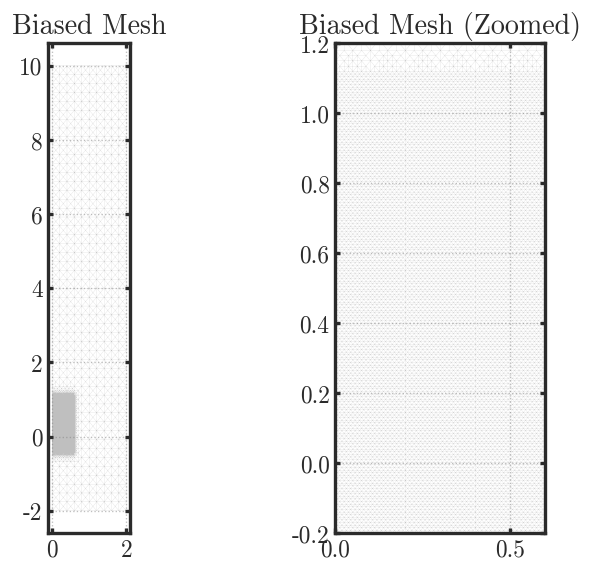

In [2]:
#@title Create mesh, subdomains & measures { form-width: "20%" }

Width, Height = 2, 10 # symmetry condition on Width --> doubled in principle
ticks_per_unit = 5
nx, ny = Width * ticks_per_unit, Height * ticks_per_unit


# Origin at left bottom corner: (0,0)
#mesh = RectangleMesh(Point(0, 0), Point(Width, Height), nx, ny, "crossed") # Point(1,2) control aspect ratio
mesh = RectangleMesh(MPI.COMM_WORLD, Point(0, -2), Point((Width), (Height)), nx, ny, "crossed") # Point(1,2) control aspect ratio



def zoom_plt(a=0, b=0.5, c=0, d=1):
    axes = plt.gca()
    axes.set_xlim([a,b])
    axes.set_ylim([c,d])



# Define mesh and subdomain:
#### RESET x[1] < 2.0 to x[1] < 1.2 ####### ####### ########
d = mesh.topology().dim()
embryo_domain = CompiledSubDomain("x[0] < 0.65 - DOLFIN_EPS && x[1] < 1.2 - DOLFIN_EPS && x[1] > - 0.5 - DOLFIN_EPS")

# Refinement using the `refine()` function and a Boolean `MeshFunction`:
for i in range(4):  # refine iteratively
    r_markers = MeshFunction("bool", mesh, d, False)
    embryo_domain.mark(r_markers, True)
    mesh = refine(mesh,r_markers)

#mesh = refine(mesh,r_markers)





fig, axes = plt.subplots(1,2, figsize = (7,5), dpi=120)
plt.subplot(1, 2, 1);
plot(mesh, title="Biased Mesh",linewidth=0.1, alpha=0.5)
#zoom_plt()

plt.subplot(1, 2, 2);
plot(mesh, title="Biased Mesh (Zoomed)",linewidth=0.1, alpha=0.5)
zoom_plt(a=-0.0, b=0.6, c=-0.2, d=1.2)

plt.tight_layout()

# Define function space for system of scalar fields (b, n, etc.)
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1,P1]) # # _1 == mRNA, _2 == [FGF8]

# Define function space
V = FunctionSpace(mesh, element)


# Define functions for scalar fields
u = Function(V)



# Measure dx for embryo domain only
#dx

class EmbryoDomain(SubDomain):
    def inside(self, x, on_boundary):
        return (between(x[1], (- 0.1, 1.2)) and between(x[0], (-0.0001, 0.60)))
embryoDomain = EmbryoDomain()

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
embryoDomain.mark(domains, 1)

dx_d = Measure('dx', domain=mesh, subdomain_data=domains)

dOmega1 = Measure('dx', domain = mesh, subdomain_data = r_markers)
dOmega = Measure('dx', domain = mesh, subdomain_data = embryo_domain)



In [3]:
#@title ### 📊🔧⚙️ Plot utility functions: { form-width: "30%" }
#@markdown * ``` clean_plot(zoom = True) ``` 
#@markdown * ``` plot_utility(u_list, fixed_levels = False) ``` 



from matplotlib import rcParams
rcParams['font.family'] = 'cmr10'
rcParams['mathtext.fontset'] = 'cm'


def clean_plot(zoom = True):
    ax = plt.gca()
    # ax.set_xlabel("$x$")
    # ax.set_ylabel("$y$")
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=True, labelcolor = '#808080')
    ax.grid(False)
    for pos in ['right','top','bottom','left']:
        ax.spines[pos].set_visible(True)
        ax.spines[pos].set_color('#808080')
        # Keep spines
    # Remove ticks and labels
    #ax.set_xticks([])
    ax.set_yticks((0.03, 0.97))
    ax.set_yticklabels(('0', 'L'))
    if zoom == True:
        zoom_plt(a=0, b=0.3, c=0, d=1.00)
    # Remove
    return

# Format colorbar
import matplotlib.ticker as ticker
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    result = r'$0.0$'
    if float(a) > 1e-8:
        result = rf'${a} \times 10^{{{b}}}$'
    return result

# def fmt(x, pos):
#     a, b = '{:.1e}'.format(x).split('e')
#     b = int(b)
#     return f'{a} e {b}'.format(a, b)

# Plot
def plot_utility(u_list, fixed_levels = False):
    nrow = 1
    ncol = len(u_list)
    fig, axs = plt.subplots(nrow, ncol)
    fig.set_size_inches(6,4)

    ax = fig.axes[0]
    plt.sca(ax)
    max_level = np.max(u_list[0].vector().get_local()) + 1e-10
    if fixed_levels:
        max_level = 0.1
    levels = np.linspace(0.0, max_level, 31) 
    p1 = plot(u_list[0], title=f' [mRNA] \n t = {float(t_):.2f} ' , levels = levels, cmap = BlkRd, extend='both')  # :.2f  -- formatting
    plt.colorbar(p1, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))
    clean_plot()

    ax = fig.axes[1]
    plt.sca(ax)
    max_level = np.max(u_list[1].vector().get_local()) + 1e-10
    if fixed_levels:
        max_level = 2.9e-3 
    levels = np.linspace(0.0, max_level, 31) 
    p2 = plot(u_list[1], title=f' [Protein] \n t = {float(t_):.2f} ' , levels = levels, cmap = BlkGr, extend='both')
    plt.colorbar(p2, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))
    clean_plot()

    plt.tight_layout()
    plt.show()



# Scientific Formatter
import matplotlib.ticker as ticker
def sci_formatter(x, pos = None):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    result = r'$0.0$'
    if abs(float(a)) > 1e-8:
        #result = rf'${a} \times 10^{{{b}}}$'
        result = rf'${a} ᴇ{{{b}}}$' 
    if b == 0:
        result = rf'${a}$'
    return result

The params are _ {'dt': 0.1, 'num_steps': 50, 'm_0_star': 1, 'beta_p_star': 5, 'D_p_star': 0.18, 'mu_m_star': 20, 'mu_p_star': 1.5}


<ipython-input-12-9ad5178d9cea>:178: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.colorbar(u_n1_plot, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))


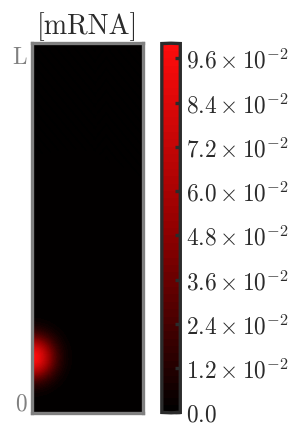

In [12]:
#@title Problem Setup { form-width: "30%" }


t_ = 0


T_final = 5.0  #@param {type: "number"} # number of time steps
num_steps = 50 #@param {type: "number"}
dt = T_final / num_steps # time step size



m_0_star = 1 #@param {type: "number"} # mRNA production

mu_m_star = 20 #@param {type: "number"} # degradation rate

D_p_star = 0.18 #@param {type: "number"} # diffusion coeff
mu_p_star = 1.5 #@param {type: "number"} # degradation rate
beta_p_star = 5 #@param {type: "number"} # conversion rate of mRNA to protein


L_domain = 1.0 # scaler - equivalent to FIXED @ 1
v_grad = 1.0 # scaler - equivalent to FIXED @ 1


param_dict = {
              'dt' : dt                     ,
              'num_steps' : num_steps       ,
              'm_0_star' : m_0_star         ,
              'beta_p_star' : beta_p_star   ,
              'D_p_star' : D_p_star         ,
              'mu_m_star' : mu_m_star       ,
              'mu_p_star' : mu_p_star       ,
              }



star_params_str = ['v_grad_star','D_p_star', 'mu_p_star', 'beta_p_star', 'mu_m_star']

star_params_labels = ['$v^*_{DoT}$ Gradient Velocity', '$D_p^*$ Protein Diffusivity', '$μ_p^*$ Protein Decay', '$β_p^*$ Protein Production', '$μ_m^*$ mRNA Decay']
star_params_labels_dict = dict(zip(star_params_str, star_params_labels))




print(f'The params are _ {param_dict}')

### ----------------------- ###

# Define function space for system of scalar fields (b, n, etc.)
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1,P1]) # # _1 == mRNA, _2 == [FGF8]

# Define function space
V = FunctionSpace(mesh, element)

# Define test functions
v_1, v_2 = TestFunctions(V)

# Define functions for scalar fields
# and split to access components
u = Function(V)
u_1, u_2  = split(u) # u_1 == mRNA, u_2 == [FGF8]

# u_n = Function(V)
# u_n1, u_n2, un_3 = split(u_n)


# Define expressions used in variational forms
#D_1 = Constant(D_1)
D_p_star = Constant(D_p_star)
mu_m_star = Constant(mu_m_star)
mu_p_star = Constant(mu_p_star)

# dt = Constant(dt)  ## dont do it - breaks string formatting for plots


# Define variational problem

# # Define boundary condition
# assume homogeneous Neumann boundary 
# conditions on the entire boundary for u1, u2
# that is, \partial u_i/ \partial n = 0

def boundary(x, on_boundary):
    return on_boundary


def boundary_x_left(x, on_boundary):
    return on_boundary and (near(x[1], -2, 0.05))



def boundary_NOT_x_left(x, on_boundary):   # use this for symmetry condition
    return on_boundary and not (near(x[0], 0, 1e-5))


# # Define boundaries

bc1_zero = DirichletBC(V.sub(0), Constant(0), boundary_NOT_x_left)
bc2_zero = DirichletBC(V.sub(1), Constant(0), boundary_NOT_x_left)
bc1_zero_plus = DirichletBC(V.sub(0), Constant(0), boundary_x_left)
bc2_zero_plus = DirichletBC(V.sub(1), Constant(0), boundary_x_left)




bcs = [bc1_zero, bc2_zero, bc1_zero_plus, bc2_zero_plus]




# mRNA initial conditions - moving gaussian
# mesh VS embryo L
embryo_L = 1.0
x_0, y_0 = Width * 0.0, embryo_L * 0.15  # Initialize in middle of ML axis and ~ to of AP axis
u_0 = Expression(('dt * m_0_star * exp(-a*(pow((x[0]-x_0), 2) + pow((x[1]-y_0), 2)))', '0'),
                degree=1, dt = dt, m_0_star = m_0_star, a=350, x_0 = x_0, y_0 = y_0)


#disp_grad = t_*v_grad

u_n = interpolate(u_0, V)
u_n1, u_n2  = split(u_n)

## Plot IC
# fig, (ax1,ax2) = plt.subplots(1, 2)
# axes = [ax1, ax2]
# for i, u_plot in enumerate([u_n3, u_n2]):
#     plt.sca(axes[i])
#     p_01 = plot(u_plot)
#     plt.colorbar(p_01)



######
# SET VELOCITY O ZERO _ NO ADVECTION
# v_grad = 0.0
#####
v_DoT = Expression(('0', 'v_grad'), degree=1, v_grad = v_grad)  # velocity of Domain of Transcription -- also that of the frame of reference 
# hence the advection terms

# Define variational problem
### for tutorial / help: https://fenicsproject.org/pub/tutorial/html/._ftut1010.html

F_1 = (
      ((u_1-u_n1)/dt)*v_1*dx    #  time derivative (Backward Euler)
      + dot(v_DoT,grad(u_1))*v_1*dx  # Advection
      + mu_m_star*u_1*v_1*dx         # decay rate
      )
    # + D_1*dot(grad(u_1), grad(v_1))*dx

F_2 = (
      ((u_2-u_n2)/dt)*v_2*dx    #  time derivative (Backward Euler)
       + dot(v_DoT,grad(u_2))*v_2*dx  # Advection
       + D_p_star*dot(grad(u_2), grad(v_2))*dx   # Diffusion
       - beta_p_star*u_1*v_2*dx        # production rate
       + mu_p_star*u_2*v_2*dx        # decay rate
      )



F = F_1 + F_2 #+ F_s
    
#problem_setup()

# Time-stepping
#u = Function(V)
t_ = 0
early_stop_counter = 0


#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
plt.set_cmap("cividis");
u_n1_plot = plot(u_n1, levels = np.linspace(0.0, m_0_star*dt, 51), title = '[mRNA]', extend='both', cmap = BlkRd)
plt.colorbar(u_n1_plot, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))
clean_plot(zoom = True)
#plt.yticks([0, 1], ['0', 'L'])
# ax = plt.gca()
# ax.set_yticks([0, 1])
# ax.set_yticklabels(['0', 'L'])

0.10
0.20
0.30
0.40
0.50
0.60
0.70
0.80
0.90
1.00
1.10
1.20
1.30
1.40
1.50
1.60
1.70
Early stop - steady state solution


<ipython-input-3-0c368fbfa7e3>:51: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axs = plt.subplots(nrow, ncol)
<ipython-input-3-0c368fbfa7e3>:61: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.colorbar(p1, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))
<ipython-input-3-0c368fbfa7e3>:71: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.colorbar(p2, format=ticker.FuncFormatter(fmt),  extendfrac = (0.001,0.001))


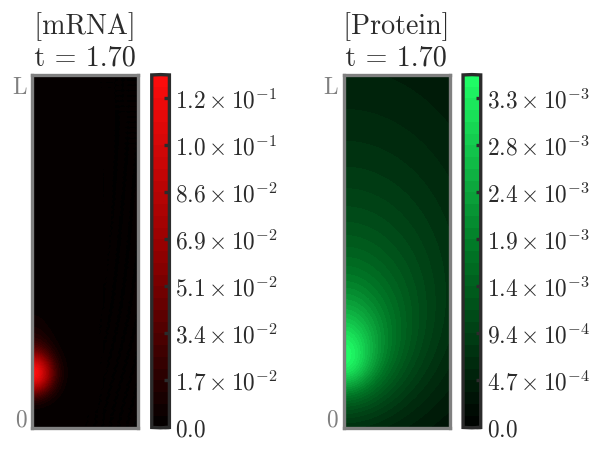

In [13]:
#@title 📈 Solve loop:  "in-notebook" plotting { form-width: "20%" }

# # Initialize problem variables + weak forms
# V, u, u_1, u_2, u_n1, u_n2, v_1, v_2, bc, early_stop_counter = problem_setup_initialization(u_0, param_dict)
# %run setup_initialize.py


# Store snapshots of solutions
u_stored_timepoints_list = []




t_ = 0


 

for n in range(num_steps):
    
    ### PLOT Initial condition ###
    _u_1, _u_2 = u_n.split(deepcopy=True) # for plotting & assemble error
    u_list = [_u_1, _u_2]


    ### SOLVE ###


    # Compute solution
    #solve(F == 0, u, solver_parameters={"newton_solver":{"relative_tolerance":1e-8}})
    solve(F == 0, u, bcs)
    # plot snapshots

    _u_1, _u_2 = u.split(deepcopy=True) # for plotting & assemble error



    # add u to list of solutions for plotting later
    u_stored_timepoints_list.append(u.copy(deepcopy=True)) # need deep copy or would be updates as an object
    
    # Check if it reached steady state, else continue the loop
    if (assemble(((_u_2 - u_n2)**2)*dx_d(1))) < np.max(_u_2.vector().get_local()) * 1e-8:
        early_stop_counter = early_stop_counter + 1
    if early_stop_counter > 3:
        print("Early stop - steady state solution")
        break

    # Update previous solution
    t_ = t_ + dt
    print(f'{t_:.2f}')
    #u_0.disp_grad = t_*v_grad
    u_0_ = interpolate(u_0, V)
    #u_n1, u_n2  = split(u_n)
    u_n.assign(u + u_0_ )
    # u_n.assign(u)
    u_n1, u_n2 = split(u_n)


# u_plot_list = [u_stored_timepoints_list[i] for i in [0,-1]]

# for u__ in u_plot_list:
#     _u_1, _u_2 = u__.split(deepcopy=True)
#     u_list = [_u_1, _u_2]
#     # Plot
#     plot_utility(u_list, fixed_levels = False)

plot_utility(u_list, fixed_levels = False)


<ipython-input-14-63be2b9aefaa>:33: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(figsize = (5,2), dpi=dpi)
<ipython-input-14-63be2b9aefaa>:59: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, axes = plt.subplots(figsize = (5,2), dpi=dpi)


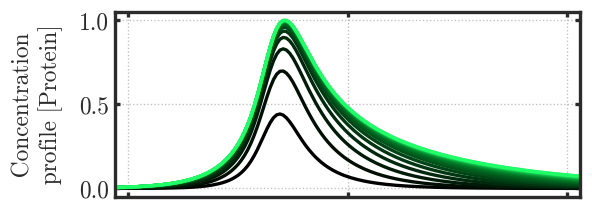

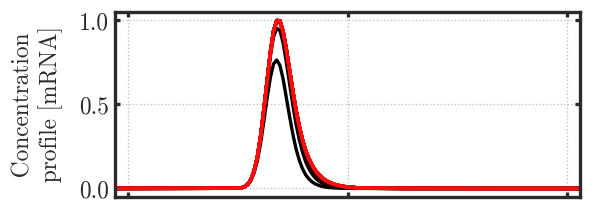

In [14]:
#@title FIGURE - Plot final metrics { form-width: "20%" }




tol = 0.001  # avoid hitting points outside the domain
y = np.linspace(-0.5 + tol, embryo_L * 2 - tol, 201)  # fix heights
x_pos = 0 + 0.01
points = [(x_pos, y_) for y_ in y]  # 2D points

u_1_stored_list, u_2_stored_list = [], []
# Choose stored list - either directly from simulation run above, or read from saved file (_read)
try:
    stored_list = u_stored_timepoints_list #@param ["u_stored_timepoints_list", "u_stored_timepoints_list_read"] {type:"raw"}
except NameError:
    stored_list = u_stored_timepoints_list_read

for u in stored_list:   # or u_stored_timepoints_list_read
    u_1, u_2 = split(u)
    u_1_stored_list.append(u_1)
    u_2_stored_list.append(u_2)

#Iterate color to match time progression
n_colors = len(u_2_stored_list)
from matplotlib.pyplot import cm
summer = plt.get_cmap('YlGn')  # my_cmap
color = iter(summer(np.linspace(0, 1, n_colors)))


dpi = 120

with plt.style.context('/content/scientific.mplstyle'):
    fig, axes = plt.subplots(figsize = (5,2), dpi=dpi)



    # FGF Profile

    cmap_choose = BlkGr  # my_cmap
    color = iter(cmap_choose(np.linspace(0, 1, n_colors)))

    u_norm_FGF = np.max(np.array([u_2_stored_list[-1](point) for point in points]))
    for u_2 in u_2_stored_list:
        c = next(color)
        u_line = np.array([u_2(point) for point in points]) / u_norm_FGF
        axes_2 = axes.plot(y, u_line, "-", c = c) #, label=f"u_x @ x = {x_pos}") 
        #plt.plot(y, u_line[:,1], "-", c = c, label=f"u_y @ x = {x_pos}") 

    plt.xlim([-0.45,1.35])
    plt.xticks([-0.4, 0.45, 1.3])
    axes.set_xticklabels([ ])

    # Labels
    #plt.xlabel('Position on Anteroposterior axis (y)')
    plt.ylabel(' Concentration \n profile [Protein] ')


    # mRNA
    fig, axes = plt.subplots(figsize = (5,2), dpi=dpi)

    cmap_choose = BlkRd

    color = iter(cmap_choose(np.linspace(0, 1, n_colors)))
    u_norm_mRNA = np.max(np.array([u_1_stored_list[-1](point) for point in points]))

    for u_1 in u_1_stored_list:
        c = next(color)
        u_line = np.array([u_1(point) for point in points]) / u_norm_mRNA
        axes_1 = axes.plot(y, u_line, "-", c = c, alpha = 1.0) #, label=f"u_x @ x = {x_pos}") 
        #plt.plot(y, u_line[:,1], "-", c = c, label=f"u_y @ x = {x_pos}") 

    plt.xlim([-0.45,1.35])
    plt.xticks([-0.4, 0.45, 1.3])
    axes.set_xticklabels([ ])

    ### Legend - manually 
    # plt.legend(['mRNA', 'Protein'])
    # ax = plt.gca(); leg = ax.get_legend()
    # leg.legendHandles[0].set_color('red'); leg.legendHandles[1].set_color('#20ff67')
    
    # Labels
    #plt.xlabel('Position on Anteroposterior axis (y)')
    plt.ylabel(' Concentration \n profile [mRNA] ')


plt.show()




In [15]:
### Save single sol

folder_name =  "solutions"

# %cd $folder_path
%mkdir $folder_name
%cd ./$folder_name

sol = u_stored_timepoints_list[-1]

### Saving
fFile = HDF5File(MPI.COMM_WORLD, "u_f_final.h5","w")
fFile.write(sol, f"/final")
fFile.close()
print("u_final.h5")

/content/solutions
u_final.h5


# ACTIVE FLUID (Mechanics)

In [16]:
#@title Parameters { form-width: "20%" }


v_tb = 50 * 10**(-6) / (3600)  # 50 um per hour  1.3888888888888887e-08

# T_scale (L / v_tb)	3.60E+04
T_scale = 3.60E+04
#def problem_setup():
t_ = 0
#T = 10000 #@param {type: "number"} # final time
#@markdown (T_final is in units of  T_scale = 10 hrs)
T_final = 1.6  #@param {type: "number"} # number of time steps
num_steps = 20 #@param {type: "number"}
dt = T_final / num_steps # time step size
#T = dt * num_steps
#num_steps = int(T_final/dt + 1)

K_star = 10 #@param {type: "number"} # ratio of bulk to shear viscosity

eta_star = 1 #@param {type: "number"} # shear viscosity

s_star = 100000 #@param {type: "number"} # FGF depenndent active stress

b_ecm_star = 0.5 #@param {type: "number"} # viscous drag




L_domain = 1.0 # scaler - equivalent to FIXED @ 1
v_tb = 1.0 # scaler - equivalent to FIXED @ 1






# Time (simulation) parameters 
# bcs T_scale depends on material properties

# T_scale = E_modulus * Viscosity
t_ = 0
# HH 14 --> HH 18  (52 --> 72 hrs)  --> 20 hrs
T = 20.0 * 3600 / T_scale             # final time


grad_x_final = - v_tb * T



# Reset to default parameter values
params_str = ['eta_star', 'K_star',  's_star', 'b_ecm_star']
#params = [eta_star, s_star, b_ecm_star]

default_params = [ eta_star ,  K_star ,   s_star ,  b_ecm_star ]
param_dict = dict(zip(params_str, default_params))

star_params_str = ['eta_star', 'K_star',  's_star', 'b_ecm_star']
star_params_vals = [eta_star ,  K_star ,   s_star ,  b_ecm_star]
star_params_dict = dict(zip(star_params_str, star_params_vals))


# for key,value in star_params_dict.items():
#     star_params_dict[key] = star_params_dict[key]


eta_star = star_params_dict['eta_star']
K_star = star_params_dict['K_star']
s_star = star_params_dict['s_star']
b_ecm_star = star_params_dict['b_ecm_star']


# for i, default_param in enumerate(default_params):
#     params[i] = default_param

from pprint import pprint


 
print(f'The params are _ {param_dict}')
pprint(param_dict)

The params are _ {'eta_star': 1, 'K_star': 10, 's_star': 100000, 'b_ecm_star': 0.5}
{'K_star': 10, 'b_ecm_star': 0.5, 'eta_star': 1, 's_star': 100000}


In [17]:
#@title Boundary Conditions & Initial Conditions { form-width: "20%", display-mode: "both" }


# Define function space (needs mesh)

bot_boundary = -2

 
# # Define variational problem - variables
u = Function(V)
d = u.geometric_dimension() # space dimension => shape of vectors/tensors
v = TestFunction(V)




# # Lower boundary - zero movement
u_D = Expression(('0', '0.0 * t_ + 0.000'), 
                  t_ = t_, degree=2)



# Define boundaries
tol = 1E-14
def boundary_y_top(x, on_boundary):
    return on_boundary and (near(x[1], Height, tol))

def boundary_x_right(x, on_boundary):
    return on_boundary and (near(x[0], Width, tol))

def boundary_x_left(x, on_boundary):
    return on_boundary and (near(x[0], 0, tol))

# Entire bot boundary
def boundary_y_bot(x, on_boundary):
    return on_boundary and (near(x[1], bot_boundary, tol))

# # SUBDOMAIN botom boundary BC <<< !!!!
# def boundary_y_bot(x, on_boundary):
#     return on_boundary and (near(x[1], bot_boundary, tol)) and (x[0]<Width)

#bc_y_top = DirichletBC(V, Constant((0,0)), boundary_y_top)
bc_y_top = DirichletBC(V, Constant((0,0)), boundary_y_top)
bc_x_right = DirichletBC(V, Constant((0,0)), boundary_x_right) # clamped
#bc_x_right = DirichletBC(V.sub(0), Constant(0), boundary_x_right) # roller

#bc_y_bot = DirichletBC(V.sub(1), Constant(0), boundary_y_bot) # roller boundary
bc_y_bot = DirichletBC(V, u_D, boundary_y_bot) # BC
bc_x_left = DirichletBC(V.sub(0), Constant(0), boundary_x_left) # V.sub(0) --> affect only x displacement, V.sub(1) --> y displacement



class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], Height) and on_boundary
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0) and on_boundary
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0) and on_boundary

# exterior facets MeshFunction
facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
Top().mark(facets, 1)
Left().mark(facets, 2)
Bottom().mark(facets, 3)
ds = Measure('ds', subdomain_data=facets)



bcs = [bc_x_left, bc_x_right, bc_y_top, bc_y_bot]  ### <--- symmetry 



In [18]:
### READ SOLUTION FROM TRANSPORT PART



uf_stored_list = []



# Define function space for system of scalar fields (b, n, etc.)
P1 = FiniteElement('P', triangle, 1)
element = MixedElement([P1,P1]) # # _1 == mRNA, _2 == [FGF8]

# Define function space
V_mixed = FunctionSpace(mesh, element)
u_mixed = Function(V_mixed)



### Read
# for i in range(31):
#     # Re-initialize u as an empty function - for te data to be read in
#     u_read = Function(V_mixed)

#     filename = rf"u_{i}.h5"

#     fFile = HDF5File(MPI.COMM_WORLD, filename, "r")


#     fFile.read(u_read, "/_")
#     uf_stored_list.append(u_read)



# Re-initialize u as an empty function - for te data to be read in
u_read = Function(V_mixed)

filename = rf"u_f_final.h5"

fFile = HDF5File(MPI.COMM_WORLD, filename, "r")


fFile.read(u_read, "/final")
uf_stored_list.append(u_read)

In [19]:
#@title Weak Form

p_star_default = uf_stored_list[len(uf_stored_list)//2][1]
print(np.max(p_star_default))

#protein_conc = s_star * u_read[1] # * 100000 # [0] is mRNA, [1] is FGF (protein)

protein_conc = s_star * p_star_default # * 100000 # [0] is mRNA, [1] is FGF (protein)

protein_conc_default = protein_conc / s_star

s_active = protein_conc * Identity(d)

##### read value ####
# p = plot(protein_conc)
# plt.colorbar(p)



# Weak Forms

# Initialize displacement for velocity
u_0 = Constant((0,0))
u_n = interpolate(u_0, V)

# ECM force

f_ecm = b_ecm_star*u 
f_ext = f_ecm # + f_active

 
r_a = 0.5
pressure = - eta_star * div(u) / (2) + (1 - r_a) * s_active[0,0]   # from continuity law of Maha
sigma_v  = ( 2*((sym(grad(u)) - 0.5 * div(u) * Identity(d)))   # deviatoric part only
            - pressure * Identity(d)  )   # pressure
 

F_sigma_a = inner((s_active), sym(grad(v)))*dx 
F_sigma_v = inner(sigma_v, sym(grad(v)))*dx
F_ext = dot(f_ext, v)*dx  



F =  F_sigma_v + F_sigma_a + F_ext  #+ Traction_BC
### ^^ WEAK FORM #####

# Compute solution
#solve(F == 0, u, bcs) 


f_9200[1]


In [20]:
#@title SOLVE
### TIME LOOP START

u_list = []
#num_steps = 30

### for Efficiency 
max_u_array = np.zeros(num_steps)
min_u_array = np.zeros(num_steps)
min_v_array = np.zeros(num_steps)




t_ = 0


num_steps = 2  ######  SINGLE SOLVE IN THIS FORM  ######

for n in range(num_steps):
    # Compute solution
    #solve(F == 0, u, solver_parameters={"newton_solver":{"relative_tolerance":1e-8}})
    solve(F == 0, u, bcs)
    #u_abs = project(abs(u.sub(1)), V) # only for y displacment
    #max_u_array[n] = u.sub(1).vector().get_local().max()
    min_u_array[n] = u.sub(1).vector().get_local().min()




    #if n%(num_steps//num_plots) == 0:
    component_ = 1
    ## Fixed scale of colorbar in plots - go to 20 % strain
    max_level = abs(min_u_array[n]) 
    levels = np.linspace(-max_level, max_level, 51)




    # add u to list of solutions for plotting later
    u_list.append(u_n.copy(deepcopy=True)) # need deep copy or would be updates as an object
        #print(f" Final position of gradient inflection: {( x_0 - p_3 / p_2 * t_) }")
    # Update previous solution
    u_n.assign(u)

    #s_active.assign(s_active)
    # Update s_active
    #print(t_)
    t_ = t_ + dt
    
    
    # ##### UNCOMMENT for hardcoded s_active ####
    # s_active.t_ = t_  # n is used as time
    # ########################################
    
    
    
    u_D.t_ = t_  # UPDATE LOWER BOUNDARY CONDITION




# # Plot final timepoint of active stress / FGF activity
# stress_ = project(s_active[0,0], V__)
# sub_p = plot(stress_)
# plt.colorbar(sub_p)
# plt.show()
# print(f" Final position of gradient inflection: {( - v_tb * t_) }")

DEBUG:UFL:Blocks of each mode: 
  6	full
DEBUG:UFL:Blocks of each mode: 



DEBUG:UFL:Blocks of each mode: 

DEBUG:UFL:Blocks of each mode: 
  2	full
/usr/local/lib/python3.10/dist-packages/dolfin/common/plotting.py:281: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()


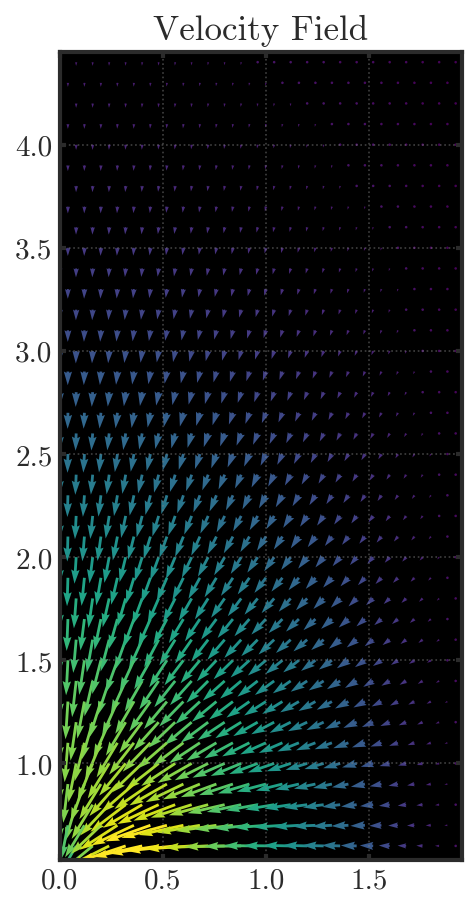

<ipython-input-21-128c33903aae>:50: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  strm = plt.streamplot(X, Y , U, V,


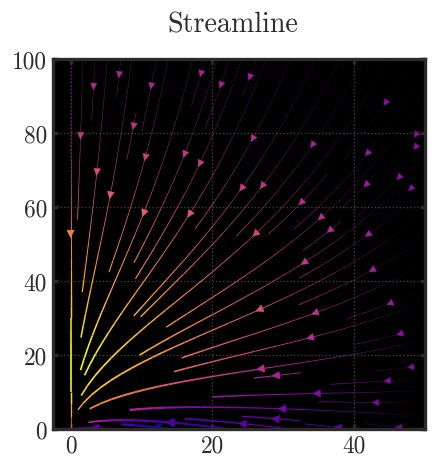

In [21]:
#@title Plot solution (display mode == displacement) { form-width: "20%" }

u = u_list[-1]

plot_style = 'glyphs' #@param ["displacement", "glyphs"]

plt.figure(figsize = (7,7), dpi=150) # put this command BEFORE the plot function

sparseness = 2 # higher is more sparse
nx, ny = 50, 100
mesh_sparse = RectangleMesh(Point(0, 0), Point(Width, Height), nx//sparseness, ny//sparseness, "crossed") # Point(1,2) control aspect ratio

V_sparse = VectorFunctionSpace(mesh_sparse, 'P', 2)

u_sparse = project(u, V_sparse)


import matplotlib.colors
norm = matplotlib.colors.Normalize(vmin=0,vmax=6.,clip=False)
cmap_ = matplotlib.colors.ListedColormap(plt.cm.viridis(np.linspace(0.0,1,100)), "name")

p = plot(u_sparse, title='Velocity Field', 
         mode=plot_style, scale=50, width = 0.007, cmap = cmap_, norm=norm); # higher scale, shorter arrow
zoom_plt(0,1.95,0.53,4.45)
plt.gca().set_facecolor('k')


plt.show()

plt.figure(dpi=120)

#x, y = mesh_sparse

#nx, ny = 100, 200
embryo_domain_ranges = [0.0, 1.95, 0.35, 3.98]  # x1, x2, y1, y2

nx, ny = int(nx), int(ny)
x = np.linspace(embryo_domain_ranges[0] + tol, embryo_domain_ranges[1] - tol, nx)  
y = np.linspace(embryo_domain_ranges[2] + tol, embryo_domain_ranges[3] - tol, ny)  
points = [(x_, y_) for y_ in y for x_ in x]  # 2D points
u_sparse_array = np.array([u(point) for point in points])

X, Y = np.meshgrid(np.linspace(0,nx,nx),np.linspace(0,ny,ny))
U, V = u_sparse_array[:,0].reshape(ny,nx),u_sparse_array[:,1].reshape(ny,nx)

speed = np.sqrt(U**2 + V**2)
lw = 1.5 *speed / speed.max()


strm = plt.streamplot(X, Y , U, V, 
                     # density=[0.9, 0.7],
               linewidth = lw,
               color= - V,
               cmap='plasma', 
               )
plt.gca().set_facecolor('k')


plt.suptitle('Streamline')

#zoom_plt(0,0.6,0.3,1.3)
plt.show()